In [1]:
import variational_bayes as vb
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

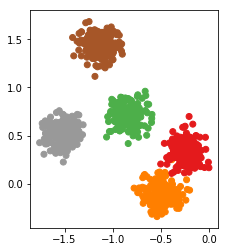

In [2]:
np.random.seed(9)
num_samples = 1000
num_groups = 5

z = np.random.choice(num_groups, num_samples)
group_mean = np.random.normal(0, 1, (num_groups, 2))
group_precision = np.random.gamma(100, 1, (num_groups, 2))

x = np.random.normal(0, 1, (num_samples, 2)) / np.sqrt(group_precision[z]) + group_mean[z]

ax = plt.gca()
ax.scatter(*x.T, c=z, cmap='Set1')
ax.set_aspect(1)

In [3]:
def mixture_model(num_groups):
    # Set up the factors
    q_mean = vb.NormalDistribution(np.random.normal(0, 1e-3, (num_groups, 2)), np.ones((num_groups, 2)) * 1e-3)
    q_precision = vb.GammaDistribution(np.ones((num_groups, 2)) * 1e-3, np.ones((num_groups, 2)) * 1e-3)
    q_z = vb.CategoricalDistribution(np.random.dirichlet(1000 * np.ones(num_groups), num_samples))
    
    # Evaluate the likelihood
    likelihood = vb.NormalLikelihood(x[:, None], q_mean, q_precision)
    mixture_likelihood = vb.MixtureLikelihood(q_z, likelihood)
    
    mean_prior = vb.NormalLikelihood(q_mean, 0, 1e-4)
    precision_prior = vb.GammaLikelihood(q_precision, 1e-3, 1e-3)
    z_prior = vb.CategoricalLikelihood(q_z, np.ones(num_groups) / num_groups)

    return vb.Model({'mean': q_mean, 'precision': q_precision, 'z': q_z}, 
                    [mixture_likelihood, mean_prior, precision_prior, z_prior])

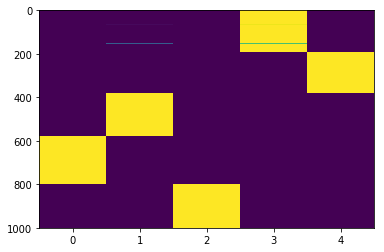

In [4]:
model = mixture_model(num_groups)
elbo = model.update(100)

plt.imshow(model['z'].mean[np.argsort(z)], aspect='auto')

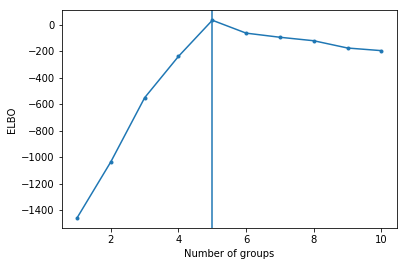

In [6]:
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
elbos = []

for n in tqdm_notebook(num):
    model = mixture_model(n)
    elbo = model.update(100)
    elbos.append(elbo[-1])
    
plt.plot(num, elbos, marker='.')
plt.axvline(num_groups)
plt.ylabel('ELBO')
plt.xlabel('Number of groups')